In [1]:
#| export
print_flag                    = None
check_memory_usage            = None
time_flag                     = None
show_plots                    = None
reset_kernel                  = None
check_parameters              = True
cuda_device                   = None
enc_artifact                  = "mvp:v93"

In [2]:
#| export
print_flag                    = True  if print_flag is None else print_flag
check_memory_usage            = True  if check_memory_usage is None else check_memory_usage
time_flag                     = True  if time_flag is None else time_flag
show_plots                    = False if show_plots is None else show_plots
reset_kernel                  = False  if reset_kernel is None else reset_kernel
cuda_device                   = 0 if  cuda_device is None else cuda_device
enc_artifact                  = "MVP:latest" if enc_artifact is None else enc_artifact

In [3]:
if check_parameters:
    print("--- Check parameters ---")
    print(
        "print_flag:", print_flag,
        "check_memory_usage", check_memory_usage,
        "time_flag:", time_flag,
        "show_plots:",show_plots,
        "reset_kernel:",reset_kernel,
        "cuda_device", cuda_device,
        "enc_artifact", enc_artifact
)

--- Check parameters ---
print_flag: True check_memory_usage True time_flag: True show_plots: False reset_kernel: False cuda_device 0 enc_artifact mvp:v93


In [4]:
#| export
# This is only needed if the notebook is run in VSCode
import sys
import dvats.utils as ut
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    ut.DisplayHandle.update = ut.update_patch

In [5]:
#| export
import dvats.config as cfg_

# Getting the embeddings

> This notebook gets the embeddings (or latent space) from a multivariate time series 
given by a encoder (e.g., autoencoder)

In [6]:
from dvats.all import *
from tsai.data.preparation import SlidingWindow
from fastcore.all import *
import wandb
wandb_api = wandb.Api()
from yaml import load, FullLoader


Octave is ready <oct2py.core.Oct2Py object at 0x7fe5be4469b0>

















## Config parameters
> Configuration parameters are obtained from 'config\03-embeddings.yaml'

### Get configuration artifact

In [7]:
config, job_type = get_artifact_config_embeddings(print_flag = False)

In [8]:
config.enc_artifact = config.enc_artifact[:config.enc_artifact.rfind('/')]+"/"+enc_artifact

In [9]:
config.enc_artifact

'mi-santamaria/deepvats/mvp:v93'

In [10]:
cfg_.show_attrdict(config)

use_wandb: True
wandb_group: embeddings
wandb_entity: mi-santamaria
wandb_project: deepvats
enc_artifact: mi-santamaria/deepvats/mvp:v93
input_ar: None
cpu: False


### Show configuration artifact

## Build W&B artifact

In [11]:
import os
path = os.path.expanduser("~/work/nbs_pipeline/")
name="07_mstamp"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
print("runname: "+runname)

runname: 07_mstamp


In [12]:
run = wandb.init(
    entity      = config.wandb_entity,
    project     = config.wandb_project if config.use_wandb else 'work-nbs', 
    group       = config.wandb_group,
    job_type    = job_type,
    mode        = 'online' if config.use_wandb else 'disabled',
    anonymous   = 'never' if config.use_wandb else 'must',
    config      = config,
    resume      = 'allow',
    name        = runname
)

wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


## Get trained model artifact

### Build artifact selector
> Botch to use artifacts offline

In [13]:
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

### Get the model from W&B
> Restore the encoder model and its associated configuration

In [14]:
enc_artifact = artifacts_gettr(config.enc_artifact, type='learner')

In [15]:
# TODO: This only works when you run it two timeS! WTF?
try:
    enc_learner = enc_artifact.to_obj()
except:
    enc_learner = enc_artifact.to_obj()

wandb:   1 of 1 files downloaded.  


## Get dataset artifact from W&B
### Restore the dataset artifact used for training the encoder. 
> Even if we do not compute the dimensionality reduction over this dataset, we need to know the metadata of the encoder training set, to check that it matches with the dataset that we want to reduce.

In [16]:
enc_run = enc_artifact.logged_by()
enc_artifact_train = artifacts_gettr(enc_run.config['train_artifact'], type='dataset')
enc_artifact_train.name

'toy:v2'

### Specify the dataset artifact that we want to get the embeddings from
> If no artifact is defined, the artifact to reduce will be the one used for validate the encoder.

In [17]:
input_ar_name = ifnone(
    config.input_ar, 
    f'{enc_artifact_train.entity}/{enc_artifact_train.project}/{enc_artifact_train.name}'
)
wandb.config.update({'input_ar': input_ar_name}, allow_val_change=True)
input_ar = artifacts_gettr(input_ar_name)
input_ar.name

'toy:v2'

In [18]:
df = input_ar.to_df()
df.head()

wandb:   1 of 1 files downloaded.  


,T3,T2,T1
1970-01-01 00:00:00,0.741822,0.637180,0.565117
1970-01-01 00:00:01,0.739731,0.629415,0.493513
1970-01-01 00:00:02,0.718757,0.539220,0.469350
1970-01-01 00:00:03,0.730169,0.577670,0.444100
1970-01-01 00:00:04,0.752406,0.570180,0.373008


In [19]:
df.shape

(550, 3)

In [20]:
enc_input, _ = SlidingWindow(window_len=enc_run.config['w'], 
                             stride=enc_run.config['stride'], 
                             get_y=[])(df)
enc_input.shape

(521, 3, 30)

In [21]:
embs = get_enc_embs(enc_input, enc_learner, cpu=config.cpu, to_numpy=True)

--> Check CUDA
--> Ensure empty cache
--> Use CUDA |Get enc embs GPU 
CUDA está disponible
Dispositivo CUDA actual:  0
Nombre del dispositivo CUDA actual:  NVIDIA GeForce RTX 3090
--> Set dataset from X (enc_learn does not contain dls)
--> Get module
--> Get enc embs bs:  1
--> Concat
Fit in GPU
--> reduce
--> 2 numpy


In [22]:
if config.use_wandb: 
    run.log_artifact(ReferenceArtifact(embs, 'embeddings', metadata=dict(run.config)), 
                     aliases=f'run-{run.project}-{run.id}')

In [23]:
run.finish()

## Dimensionality reduction using UMAP

In [24]:
config_dr, job_type = get_artifact_config_dimensionality_reduction(True)

Current: /home/macu/work/nbs_pipeline
yml: ./config/04-dimensionality_reduction.yaml
Getting content./config/04-dimensionality_reduction.yaml
... About to replace includes with content
Load content./config/04-dimensionality_reduction.yaml
enc_artifact: mi-santamaria/deepvats/mvp:latest


In [25]:
umap_params = {
    'n_neighbors' : config_dr.n_neighbors,
    'min_dist' : config_dr.min_dist,
    'random_state': config_dr.random_state
}

In [26]:
### Comprobado que es necesario para que no falle sunspot
#Ensure no nan ((Intento de Macu. La celda de comentada abajo es la original. Pero falla por Nan con sunspot))
embs_no_nan = embs[~np.isnan(embs).any(axis=1)]
embs_no_nan.shape

(521, 128)

In [27]:
prjs = get_UMAP_prjs(embs_no_nan, cpu=False, **umap_params)
prjs.shape

GPU | Used mem: 2
GPU | Used mem: 24
GPU | Memory Usage: [█-------------------] 8%
-- cuml.UMAP -- False
GPU | Used mem: 2
GPU | Used mem: 24
GPU | Memory Usage: [█-------------------] 8%


(521, 2)

In [32]:
#if config.use_wandb: 
#    run.log_artifact(ReferenceArtifact(prjs, 'projections', type='projections', 
#metadata=dict(run.config)), aliases=f'run-{run.project}-{run.id}')

In [33]:
import pandas as pd

In [36]:
import matplotlib.pyplot as plt

In [37]:
#| export
def plot_projections(prjs, umap_params, fig_size = (25,25)):
    "Plot 2D projections thorugh a connected scatter plot"
    df_prjs = pd.DataFrame(prjs, columns = ['x1', 'x2'])
    fig = plt.figure(figsize=(fig_size[0],fig_size[1]))
    ax = fig.add_subplot(111)
    ax.scatter(df_prjs['x1'], df_prjs['x2'], marker='o', facecolors='none', edgecolors='b', alpha=0.1)
    ax.plot(df_prjs['x1'], df_prjs['x2'], alpha=0.5, picker=1)
    plt.title('DR params -  n_neighbors:{:d} min_dist:{:f}'.format(
        umap_params['n_neighbors'],umap_params['min_dist']))
    return ax

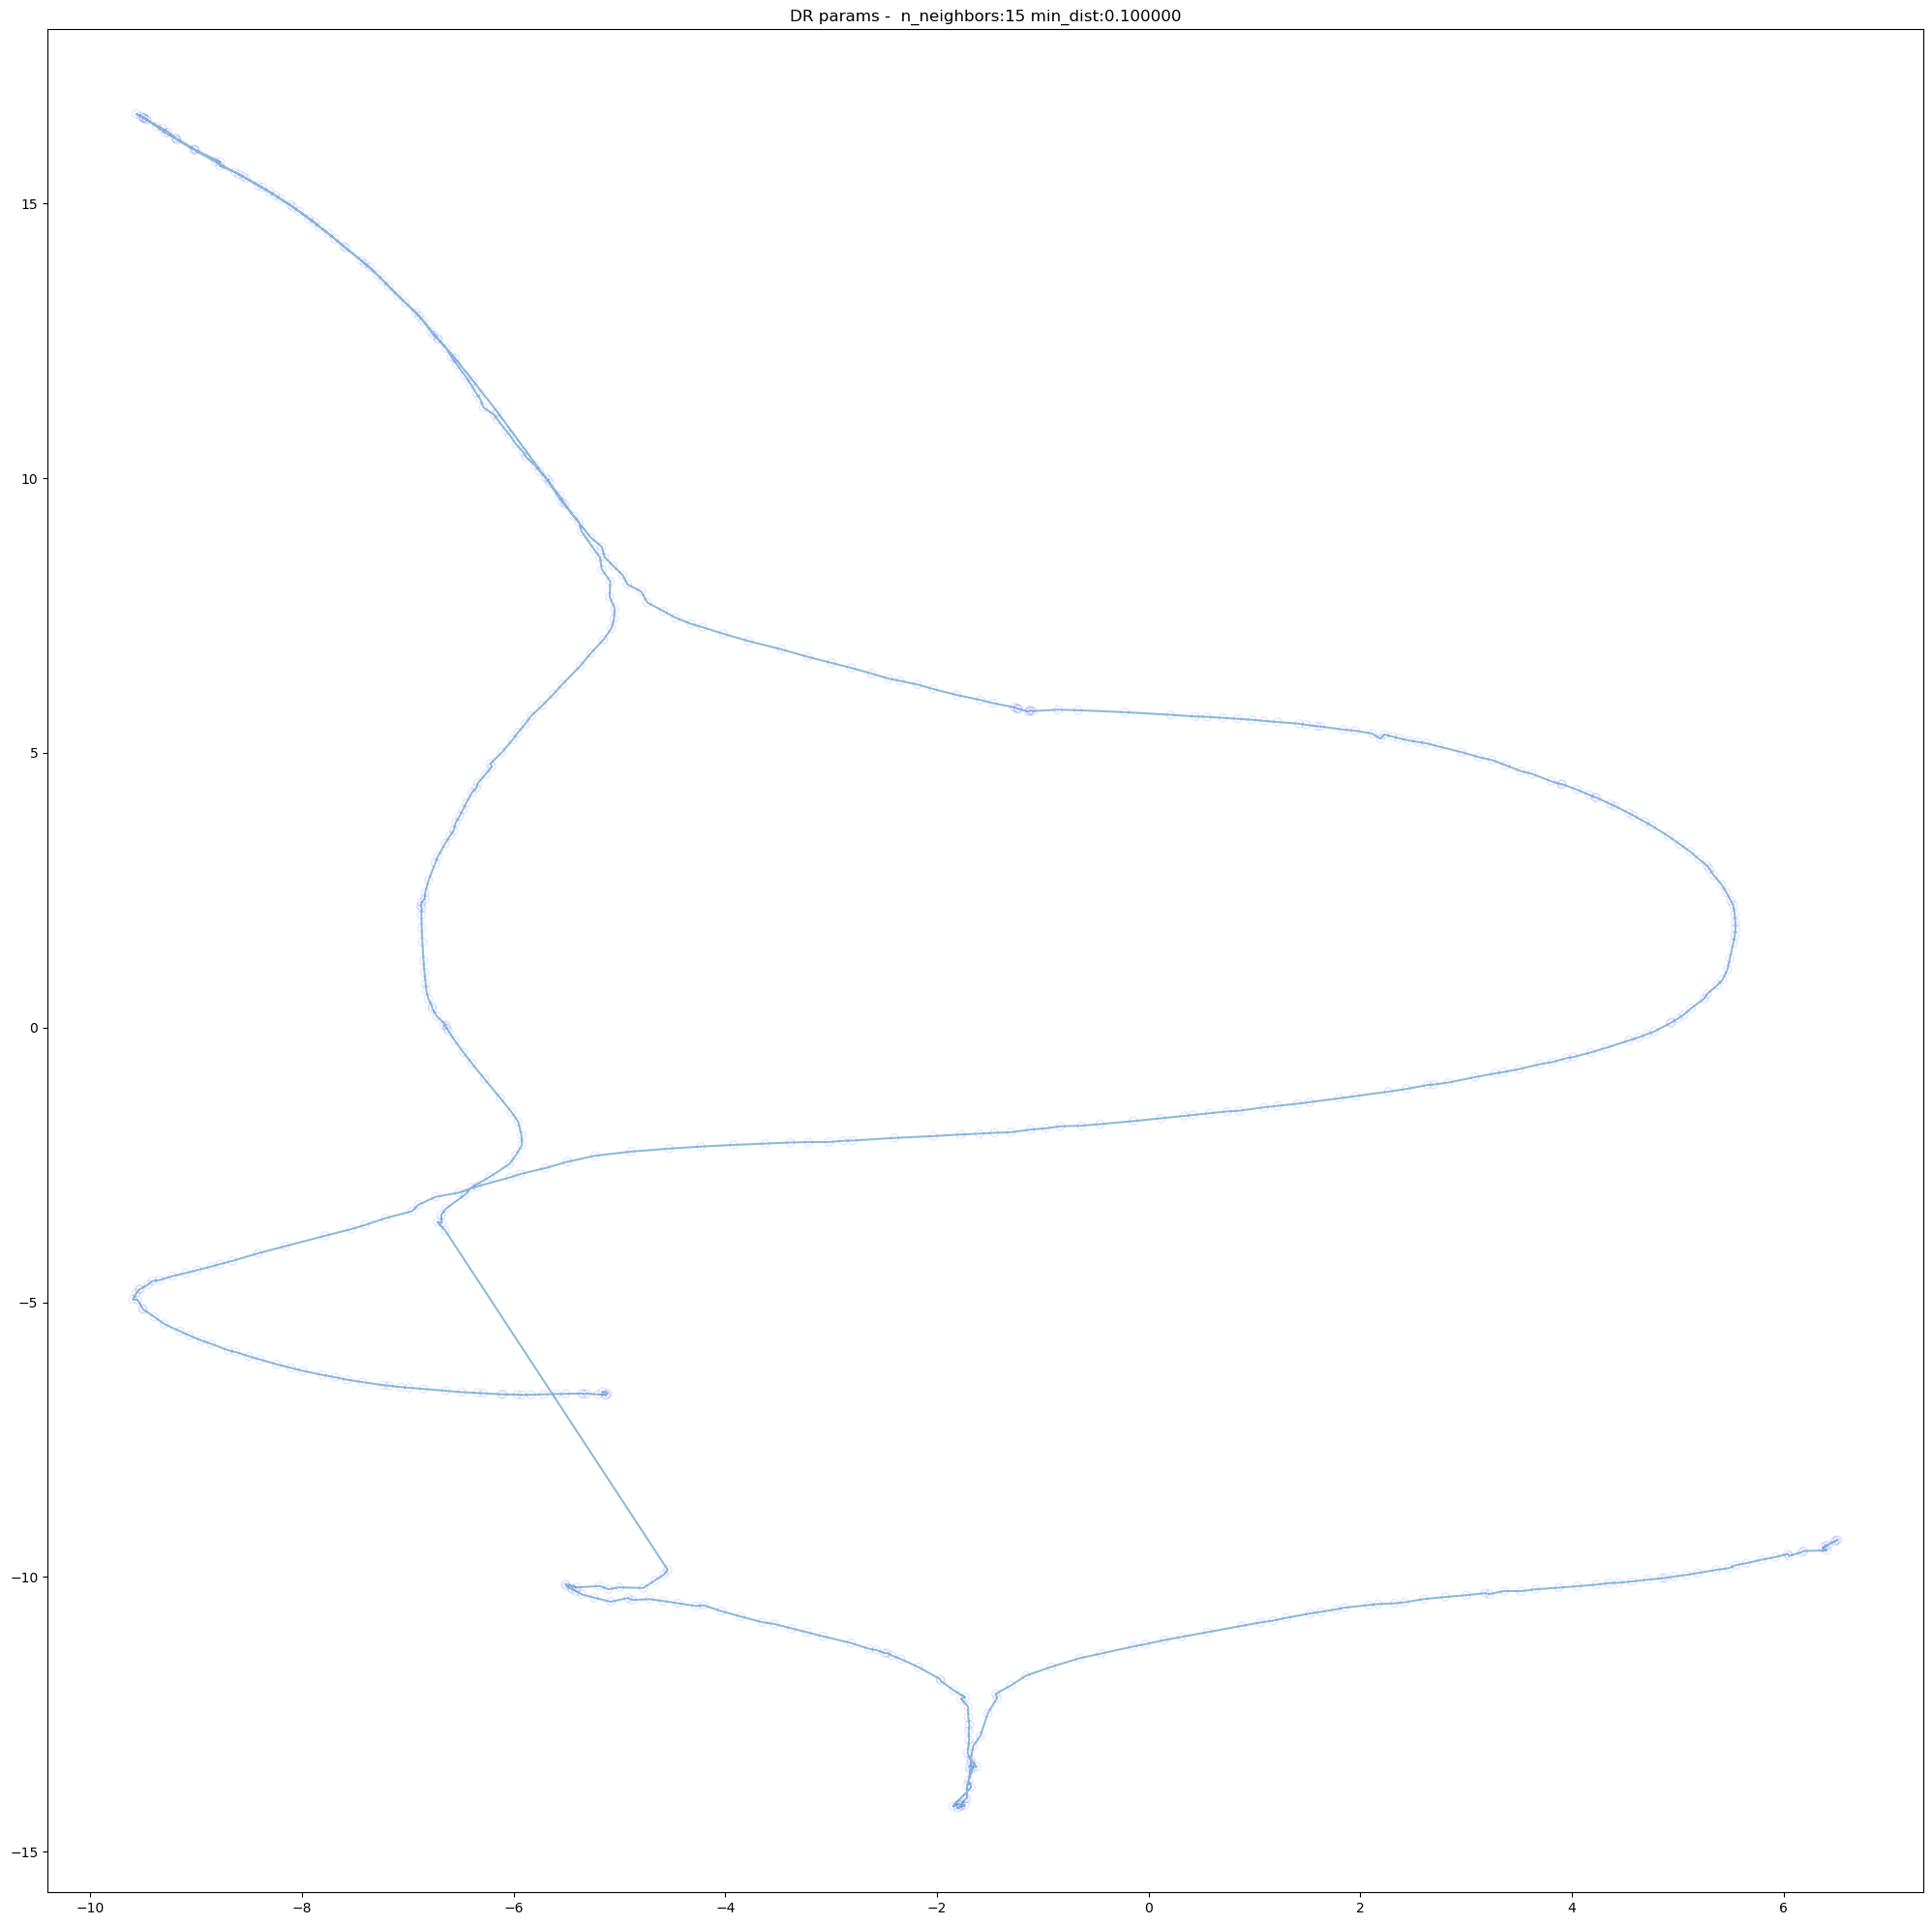

In [38]:
prjs_plt = plot_projections(prjs, umap_params)

## mSTAMP

In [39]:
def plot_motifs(data, dimensions, sub_len, matrix_profile, dimensionality=1):
    motif_at = matrix_profile[dimensionality - 1, :].argsort()[:2]
    discord_at = matrix_profile[dimensionality - 1, :].argsort()[-2:]
    print("Motifs")
    plt.figure(figsize=(14, 7))
    for i in range(3):
        plt.subplot(4, 1, i + 1)
        plt.plot(data.T[dimensions[i], :])
        plt.title('$T-{}$'.format(dimensions[i] + 1))
        for m in motif_at:
            plt.plot(range(m, m + sub_len), data.T[dimensions[i], :][m:m + sub_len], c='r')
        plt.xlim((0, matrix_profile.shape[1]))

    plt.subplot(414)
    plt.title('{}-dimensional Matrix Profile'.format(dimensionality))
    plt.plot(matrix_profile[dimensionality - 1, :])
    for m in motif_at:
        plt.axvline(m, c='r')
    plt.xlim((0, matrix_profile.shape[1]))
    plt.tight_layout()
    plt.show()
    print("Discord")
    plt.close("all")
    plt.figure(figsize=(14, 7))
    for i in range(3):
        plt.subplot(4, 1, i + 1)
        plt.plot(data.T[dimensions[i], :])
        plt.title('$T-{}$'.format(dimensions[i] + 1))
        for m in discord_at:
            plt.plot(range(m, m + sub_len), data.T[dimensions[i], :][m:m + sub_len], c='r')
        plt.xlim((0, matrix_profile.shape[1]))

    plt.subplot(414)
    plt.title('{}-dimensional Matrix Profile'.format(dimensionality))
    plt.plot(matrix_profile[dimensionality - 1, :])
    for m in discord_at:
        plt.axvline(m, c='r')
    plt.xlim((0, matrix_profile.shape[1]))
    plt.tight_layout()
    plt.show()
    return motif_at, discord_at

In [40]:
import dvats.mstamp as stamp
import scipy.io as sio

In [41]:
print(embs.shape)

(521, 128)


In [42]:
enc_input.shape[2]

30

In [43]:
embs_pro_1, embs_pro_idx_1, embs_pro_dimension = stamp.mstomp(
    embs.T, enc_input.shape[2],
    return_dimension=True
)

Progress [                                                  ]   1.6%     12.0 sec

/home/macu/work/dvats/mstamp.py:306: RuntimeWarning: divide by zero encountered in divide
  dist_profile = (2 * (sub_len - (product[sub_len - 1:seq_len] -
/home/macu/work/dvats/mstamp.py:306: RuntimeWarning: invalid value encountered in divide
  dist_profile = (2 * (sub_len - (product[sub_len - 1:seq_len] -
/home/macu/work/dvats/mstamp.py:425: RuntimeWarning: invalid value encountered in sqrt
  dist_profile = np.sqrt(dist_profile)
/home/macu/work/dvats/mstamp.py:411: RuntimeWarning: divide by zero encountered in divide
  (2 * (sub_len - (last_product[j, :] -
/home/macu/work/dvats/mstamp.py:411: RuntimeWarning: invalid value encountered in divide
  (2 * (sub_len - (last_product[j, :] -


Progress [##################################################] 100.0%      0.0 sec

In [44]:
embs_pro_1.shape

(128, 492)

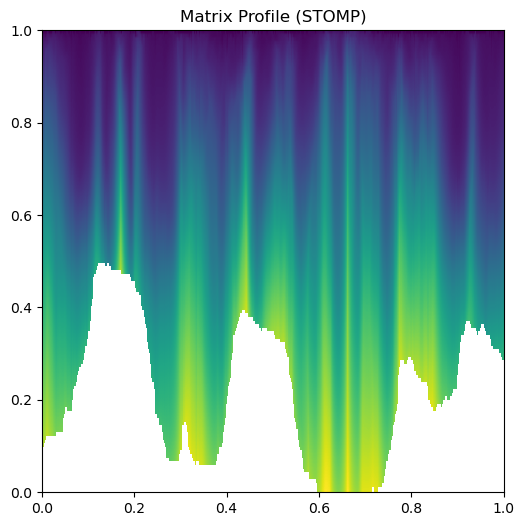

In [46]:
# plot the matrix profile as image
plt.figure()
plt.title('Matrix Profile (STOMP)')
plt.imshow(embs_pro_1, extent=[0, 1, 0, 1])

In [47]:
def find_top_k_dimensions(profile_dimension, k=3):
    # Flatten the profile_dimension list and count occurrences of each dimension
    dim_counts = np.zeros(len(profile_dimension), dtype=int)
    for dim_array in profile_dimension:
        for dims in dim_array.T:
            for dim in dims:
                dim_counts[dim] += 1
    
    # Find the top-k dimensions
    top_k_dims = np.argsort(dim_counts)[-k:][::-1]
    return top_k_dims

In [48]:
top_3_dims = find_top_k_dimensions(embs_pro_dimension, k = 3)

IndexError: index -36425618110528 is out of bounds for axis 0 with size 128

In [49]:
top_3_dims

NameError: name 'top_3_dims' is not defined

In [ ]:
# plot the matrix profile as image
plt.figure()
plt.title('Matrix Profile (STAMP)')
plt.imshow(embs_pro_2, extent=[0, 1, 0, 1])

In [50]:
motif_at, discord_at = plot_motifs(embs, top_3_dims, enc_input.shape[2], embs_pro_2, dimensionality = 3)

NameError: name 'top_3_dims' is not defined

In [ ]:
motif_at

In [ ]:
discord_at

In [83]:
prjs.shape

(521, 2)

In [51]:
import dvats.mplots as mplots

In [177]:
## -- Classes & types
from dataclasses import dataclass, field
from typing import List, Optional, Tuple, Callable
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, Layout
from IPython.display import display
from matplotlib.gridspec import GridSpec

In [198]:
#| export
@dataclass
class EmbeddingsHeatmapPlotter:
    prjs_ : List [ List [ float ] ]   = None
    prjs : List [ List [ float ] ]   = None
    embs : List [ List [ float ] ] = None
    umap_params: AttrDict = None,
    matrix_profile: List [ float ] = None
    window_len: int = None
    ids : List [ int ] = None
    dimensions : List[int] = None
    dimensionality : int = 1
    motif_id : int  = None 
    second_motif : int = None
    discord_id : int = None 
    second_discord_id : int = None
    fig = None
    axs = None
    
    def __init__(self, prjs, umap_params, matrix_profile, embs, dimensionality = 1):
        self.embs = embs
        self.prjs_ = prjs
        self.prjs = self.prjs_[:len(matrix_profile)]
        self.umap_params = umap_params
        self.matrix_profile = matrix_profile
        self.window_len = int( mplots.find_dominant_window_sizes_list(embs[0,:], offset = 0.6)[0] )
        #print(f"prjs ~ {self.prjs.shape} | mp ~ {len(self.matrix_profile)}")
        self.dimensionality = dimensionality

        for i in range(1,embs.shape[0]):
            current_size = int ( mplots.find_dominant_window_sizes_list(embs[i,:], offset = 0.6)[0] )
            self.window_len = int( (self.window_len + current_size)/2 )

        
        # Crear sliders interactivos para los umbrales
        self.threshold_min_slider = widgets.FloatSlider(value=np.min(matrix_profile), min=np.min(matrix_profile), max=np.max(matrix_profile), step=0.01, description='Threshold Min:', continuous_update=False)
        self.threshold_max_slider = widgets.FloatSlider(value=np.max(matrix_profile), min=np.min(matrix_profile), max=np.max(matrix_profile), step=0.01, description='Threshold Max:', continuous_update=False)
        self.window_size_slider   = widgets.IntSlider(value=self.window_len, min=1, max=len(matrix_profile), step=1, description='Window size:', continuous_update=False)
        self.dimensionality_slider = widgets.IntSlider(value=self.dimensionality, min=1, max=self.embs.shape[1], step=1, description='Dimensionality:', continuous_update=False)

        # Conectar los sliders a la función interactiva
        self.interactive_plot = interactive(
            self.update_plot, 
            threshold_min   = self.threshold_min_slider, 
            threshold_max   = self.threshold_max_slider,
            window_size     = self.window_size_slider,
            dimensionality  = self.dimensionality_slider
        )

        
    def plot_projections(self, threshold_min=None, threshold_max=None, fig_size=(10, 10), window_size = 1, dimensionality = 1):
        "Plot 2D projections through a connected scatter plot with heatmap coloring"
       
        # Convertir prjs a DataFrame para facilitar el manejo de datos
        df_prjs = pd.DataFrame(self.prjs, columns=['x1', 'x2'])
        self.dimensionality = dimensionality        

        
        # Aplicar umbrales si se proporcionan
        if threshold_min is not None:
            matrix_profile = np.where(self.matrix_profile < threshold_min, threshold_min, self.matrix_profile)
        if threshold_max is not None:
            matrix_profile = np.where(self.matrix_profile > threshold_max, threshold_max, self.matrix_profile)

        if self.window_len is not None:
            matrix_profile, self.ids, self.dimensions = stamp.mstomp(embs.T, self.window_len,return_dimension=True)
            matrix_profile = matrix_profile[self.dimensionality - 1, :]
            self.prjs = self.prjs_[:len(matrix_profile)]
            df_prjs = pd.DataFrame(self.prjs, columns=['x1', 'x2'])
            self.matrix_profile = matrix_profile
            self.motif_id = self.matrix_profile.argsort()[:2][0]
            self.discord_id = self.matrix_profile.argsort()[-2:][0]
            self.second_motif_id = self.matrix_profile.argsort()[2:4][0]
            self.second_discord_id = self.matrix_profile.argsort()[-4:-2][0]
            
            print(f"prjs ~ {prjs.shape} | mp ~ {len(self.matrix_profile)}")
            print(f"motif: {self.motif_id} | discord ~ {self.discord_id}")
            
            if threshold_min is not None:
                matrix_profile = np.where(self.matrix_profile < threshold_min, threshold_min, self.matrix_profile)
            if threshold_max is not None:
                matrix_profile = np.where(self.matrix_profile > threshold_max, threshold_max, self.matrix_profile)
        
        # Crear la figura y el eje para el plot
        #fig = plt.figure(figsize=(fig_size[0], fig_size[1]))
        #ax = fig.add_subplot(111)
        self.fig = plt.figure(figsize=(fig_size[0], fig_size[1]))
        gs = GridSpec(4, 1, height_ratios=[3, 1, 1, 1], figure=self.fig)  # Ajustar height_ratios según sea necesario
        self.axs = [self.fig.add_subplot(gs[i]) for i in range(4)]
        
        # Plotear los puntos con colores basados en el heatmap
        scatter = self.axs[0].scatter(df_prjs['x1'], df_prjs['x2'], c=matrix_profile, cmap='viridis', marker='o', alpha=0.7)
        
        # Añadir la conexión entre los puntos
        self.axs[0].plot(df_prjs['x1'], df_prjs['x2'], alpha=0.5, picker=1)
        
        # Añadir la barra de color para mostrar la escala de heatmap
        cbar = plt.colorbar(scatter, ax=self.axs[0])
        cbar.set_label('Heatmap Intensity')

        # Añadir título
        self.axs[0].set_title('DR params -  n_neighbors:{:d} min_dist:{:f} || MP-Window: {:d}'.format(
            self.umap_params['n_neighbors'], self.umap_params['min_dist'], self.window_len))


        ######### Toy time series plot ###########
        if self.motif_id is not None:
            i = self.discord_id
            i2 = self.second_discord_id
            x_coords = range(df.shape[0])
            slen = enc_input.shape[2]
            self.axs[1].plot(x_coords, df['T1'].values, label='TA', color = "blue")

            self.axs[1].plot(
                x_coords[i: i+ slen],
                df['T1'].values[i:i+slen],
                color = "red",
                label = ""
            )
            self.axs[1].plot(
                x_coords[i2: i2+ slen],
                df['T1'].values[i2:i2+slen],
                color = "green",
                label = ""
            )
            #ax[1].legend()
            #ax[1].set_title("T1 Subsequence_"+str(i) + "_" str(slen), fontsize = 20)
            self.axs[2].plot(x_coords, df['T2'].values, label='TA', color = "blue")
            self.axs[2].plot(
                x_coords[i: i+ slen],
                df['T2'].values[i:i+slen],
                color = "red",
                label = ""
            )
            self.axs[2].plot(
                x_coords[i2: i2+ slen],
                df['T2'].values[i2:i2+slen],
                color = "green",
                label = ""
            )
            #ax[2].legend()
            #ax[2].set_title("T1 Subsequence_"+str(i) + "_" str(slen), fontsize = 20)
            self.axs[3].plot(x_coords, df['T3'].values, label='TA', color = "blue")
            self.axs[3].plot(
                x_coords[i: i+ slen],
                df['T3'].values[i:i+slen],
                color = "red",
                label = ""
            )
            self.axs[3].plot(
                x_coords[i2: i2+ slen],
                df['T3'].values[i2:i2+slen],
                color = "green",
                label = ""
            )
            #ax[3].legend()
            #ax[3].set_title("T1 Subsequence_"+str(i) + "_" str(slen), fontsize = 20)
                          
                
        ###################
        plt.tight_layout()    
        plt.show()
    
    def update_plot(self, threshold_min, threshold_max, window_size, dimensionality):
        self.plot_projections(threshold_min = threshold_min, threshold_max = threshold_max, window_size = window_size, dimensionality = dimensionality)
    
    def display(self):
        # Mostrar los sliders y el plot
        display(self.interactive_plot)


In [ ]:
embs.shape

In [ ]:
embs.shape[0]-enc_input.shape[2]+1

In [ ]:
embs_pro_1.shape

In [55]:
mp = embs_pro_1.T
mp.shape

(492, 128)

In [56]:
dimensionality = 3
mp = mp[:,dimensionality-1]

In [ ]:
print(prjs.shape)
print(mp.shape)

In [ ]:
prjs[:,0].shape

In [ ]:
embs.shape

In [ ]:
embs[0,:].shape

In [ ]:
int(mean_size)

In [67]:
prjs.shape

(521, 2)

In [66]:
mp.shape

(492,)

In [96]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="divide by zero encountered in divide")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in divide")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in sqrt")

In [199]:
plotter = EmbeddingsHeatmapPlotter(
    prjs = prjs, 
    umap_params = umap_params, 
    matrix_profile = mp, 
    embs = embs
)
plotter.display()



interactive(children=(FloatSlider(value=0.10823036473401733, continuous_update=False, description='Threshold M…

In [126]:
plotter.discord_id

array([115, 334])

In [ ]:
from dvats.imports import beep
beep(1)
if reset_kernel:
    import os
    os.exit(00)